# Enhanced Skin Cancer Detection Using Diffusion-Based Data Augmentation and Vision Transformers

## Installing Libraries

In [20]:
# %pip uninstall -y torch torchvision
# %pip install torch==2.5.0 torchvision==0.20.0
# %pip install evaluate
# %pip install wandb
# %pip install huggingface_hub
# %pip install torch==2.5.0 torchvision==0.20.0 --index-url https://download.pytorch.org/whl/cu121
# %pip install tensorboard

In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments

import wandb

c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

### Load Training and Testing Data

#### Secret

In [ ]:
# from datasets import load_dataset, DatasetDict
# from datasets import Image

# column_names = ["image_id", "label"]
# data_files_2016 = {"train": "datasets/ISIC2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv"}
# data_files_2017 = {"train": "datasets/ISIC2017/ISIC-2017_Training_Part3_GroundTruth.csv"}

# dataset2016 = load_dataset("csv", data_files=data_files_2016, column_names=column_names)

# image_directory = "datasets/ISIC2016/ISBI2016_ISIC_Part1_Training_Data/"

# def load_images(example):
#     example["image"] = f"{image_directory}{example['image_id']}"  
#     return example

# dataset = dataset["train"].map(load_images)
# dataset = dataset.cast_column("image", Image())
# dataset

KeyError: "Column train not in the dataset. Current columns in the dataset: ['image_id', 'label', 'image']"

In [ ]:
#smote images
def create_image_dataframe(base_dir):
    image_ids = []
    labels = []
    file_paths = []

    for label in ['0', '1']: 
        label_dir = os.path.join(base_dir, label)
        for image_name in os.listdir(label_dir):
            if image_name.endswith(".jpg"): 
                image_id = image_name.split('.')[0]
                image_ids.append(image_id)
                labels.append(int(label))
                file_path = os.path.join(label_dir, image_name)
                file_paths.append(file_path)

    df = pd.DataFrame({
        'image_id': image_ids,
        'label': labels,
        'file_path': file_paths,
    })
    
    return df
base_dir = 'datasets/ISIC2016/smote_images'
#train_labels_df = create_image_dataframe(base_dir)

#### 2016 Dataframe

In [2]:
def process_dataset(csv_file, image_dir, label_map):
    labels_df = pd.read_csv(csv_file, header=None, names=['image_id', 'label'])
    labels_df['label'] = labels_df['label'].map(label_map)
    labels_df['file_path'] = labels_df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    
    return labels_df

label_map_train = {'benign': 0, 'malignant': 1}
label_map_test = {0.0: 0, 1.0: 1}

train_csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
train_image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Training_Data'

test_csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'
test_image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Data'

train_labels_df_2016 = process_dataset(train_csv_file, train_image_dir, label_map_train)
test_labels_df_2016 = process_dataset(test_csv_file, test_image_dir, label_map_test)
validation_labels_df_2016, test_labels_df_2016 = train_test_split(test_labels_df_2016, test_size=0.5, random_state=42)

print(train_labels_df_2016.head())

       image_id  label                                          file_path
0  ISIC_0000000      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
1  ISIC_0000001      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
2  ISIC_0000002      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
3  ISIC_0000004      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
4  ISIC_0000006      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...


#### 2017 Dataframe

In [3]:
# def process_dataset(csv_file, image_dir, label_map):
#     labels_df = pd.read_csv(csv_file)
#     labels_df = labels_df.drop(columns=['seborrheic_keratosis'])
#     labels_df = labels_df.rename(columns={'melanoma': 'label'}) 
#     labels_df['label'] = labels_df['label'].map(label_map)
#     labels_df['file_path'] = labels_df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    
#     return labels_df

# label_map = {0.0: 0, 1.0: 1}

# train_csv_file = 'datasets/ISIC2017/ISIC-2017_Training_Part3_GroundTruth.csv'
# train_image_dir = 'datasets/ISIC2017/ISIC-2017_Training_Data'

# validation_csv_file = 'datasets/ISIC2017/ISIC-2017_Validation_Part3_GroundTruth.csv'
# validation_image_dir = 'datasets/ISIC2017/ISIC-2017_Validation_Data'

# test_csv_file = 'datasets/ISIC2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv'
# test_image_dir = 'datasets/ISIC2017/ISIC-2017_Test_v2_Data'

# train_labels_df_2017 = process_dataset(train_csv_file, train_image_dir, label_map)
# test_labels_df_2017 = process_dataset(test_csv_file, test_image_dir, label_map)
# validation_labels_df_2017 = process_dataset(validation_csv_file, validation_image_dir, label_map)

# print(train_labels_df_2017.head())


       image_id  label                                          file_path
0  ISIC_0000000      0  datasets/ISIC2017/ISIC-2017_Training_Data\ISIC...
1  ISIC_0000001      0  datasets/ISIC2017/ISIC-2017_Training_Data\ISIC...
2  ISIC_0000002      1  datasets/ISIC2017/ISIC-2017_Training_Data\ISIC...
3  ISIC_0000003      0  datasets/ISIC2017/ISIC-2017_Training_Data\ISIC...
4  ISIC_0000004      1  datasets/ISIC2017/ISIC-2017_Training_Data\ISIC...


#### Merge Dataframes

In [4]:
# merged_df = pd.merge(train_labels_df_2016, train_labels_df_2017, on='image_id', how='outer', suffixes=('_1', '_2'))
# merged_df_validation = pd.merge(validation_labels_df_2016, validation_labels_df_2017, on='image_id', how='outer', suffixes=('_1', '_2'))
# merged_df_test = pd.merge(test_labels_df_2016, test_labels_df_2017, on='image_id', how='outer', suffixes=('_1', '_2'))

# merged_df['label'] = merged_df['label_1'].fillna(merged_df['label_2']).astype(int)
# merged_df['file_path'] = merged_df['file_path_1'].fillna(merged_df['file_path_2'])
# merged_df_validation['label'] = merged_df_validation['label_1'].fillna(merged_df_validation['label_2']).astype(int)
# merged_df_validation['file_path'] = merged_df_validation['file_path_1'].fillna(merged_df_validation['file_path_2'])
# merged_df_test['label'] = merged_df_test['label_1'].fillna(merged_df_test['label_2']).astype(int)
# merged_df_test['file_path'] = merged_df_test['file_path_1'].fillna(merged_df_test['file_path_2'])

# final_df = merged_df[['image_id', 'label', 'file_path']]
# final_df_validation = merged_df_validation[['image_id', 'label', 'file_path']]
# final_df_test = merged_df_test[['image_id', 'label', 'file_path']]

#### Final_df

In [12]:
final_df_training = train_labels_df_2016
final_df_validation = validation_labels_df_2016
final_df_test = test_labels_df_2016

### Dataset Characterization and Visualization

In [4]:
def characterize_dataset(df):
    print("DataFrame Shape:", df.shape)
    print("\nDataFrame Info:")
    print(df.info())
    print("\nColumn Names:")
    print(df.columns.tolist())
    print("\nNull Values Count:")
    print(df.isnull().sum())
    print("\nLabel Distribution:")
    print(df['label'].value_counts(dropna=False))
    print("\nFirst few rows:")
    print(df.head())
    print("\nNumber of duplicate image_ids:", df['image_id'].duplicated().sum())

    widths, heights = [], []
    class_counts = df['label'].value_counts()
    
    for idx, row in df.iterrows():
        image = Image.open(row['file_path'])
        widths.append(image.size[0])
        heights.append(image.size[1])
    
    plt.figure(figsize=(5, 3))
    plt.hist2d(widths, heights, bins=60, cmap='viridis')
    plt.colorbar(label='Number of Images')
    plt.title("Distribution of Image Sizes")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

Train
DataFrame Shape: (900, 3)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   900 non-null    object
 1   label      900 non-null    int64 
 2   file_path  900 non-null    object
dtypes: int64(1), object(2)
memory usage: 21.2+ KB
None

Column Names:
['image_id', 'label', 'file_path']

Null Values Count:
image_id     0
label        0
file_path    0
dtype: int64

Label Distribution:
0    727
1    173
Name: label, dtype: int64

First few rows:
       image_id  label                                          file_path
0  ISIC_0000000      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
1  ISIC_0000001      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
2  ISIC_0000002      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
3  ISIC_0000004      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
4  ISIC_0000006 

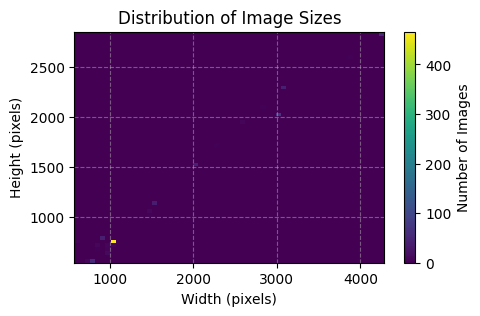

Validation
DataFrame Shape: (189, 3)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 11 to 102
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   189 non-null    object
 1   label      189 non-null    int64 
 2   file_path  189 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.9+ KB
None

Column Names:
['image_id', 'label', 'file_path']

Null Values Count:
image_id     0
label        0
file_path    0
dtype: int64

Label Distribution:
0    152
1     37
Name: label, dtype: int64

First few rows:
         image_id  label                                          file_path
11   ISIC_0000040      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
262  ISIC_0010231      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
185  ISIC_0009889      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
211  ISIC_0009980      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
1

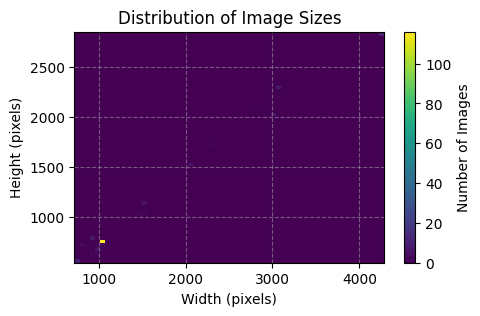

Test
DataFrame Shape: (190, 3)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 288 to 38
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   190 non-null    object
 1   label      190 non-null    int64 
 2   file_path  190 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.9+ KB
None

Column Names:
['image_id', 'label', 'file_path']

Null Values Count:
image_id     0
label        0
file_path    0
dtype: int64

Label Distribution:
0    152
1     38
Name: label, dtype: int64

First few rows:
         image_id  label                                          file_path
288  ISIC_0010451      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
283  ISIC_0010379      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
327  ISIC_0011092      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
145  ISIC_0001685      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
55   IS

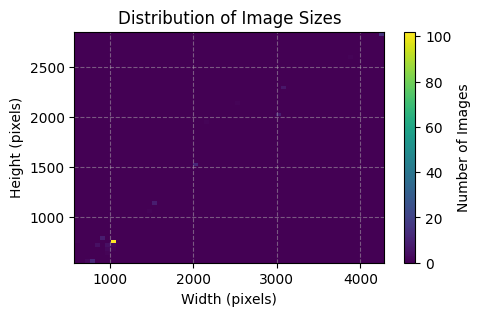

In [13]:
print("Train")
characterize_dataset(final_df_training)
print("Validation")
characterize_dataset(final_df_validation)
print("Test")
characterize_dataset(final_df_test)

### Plotting Samples


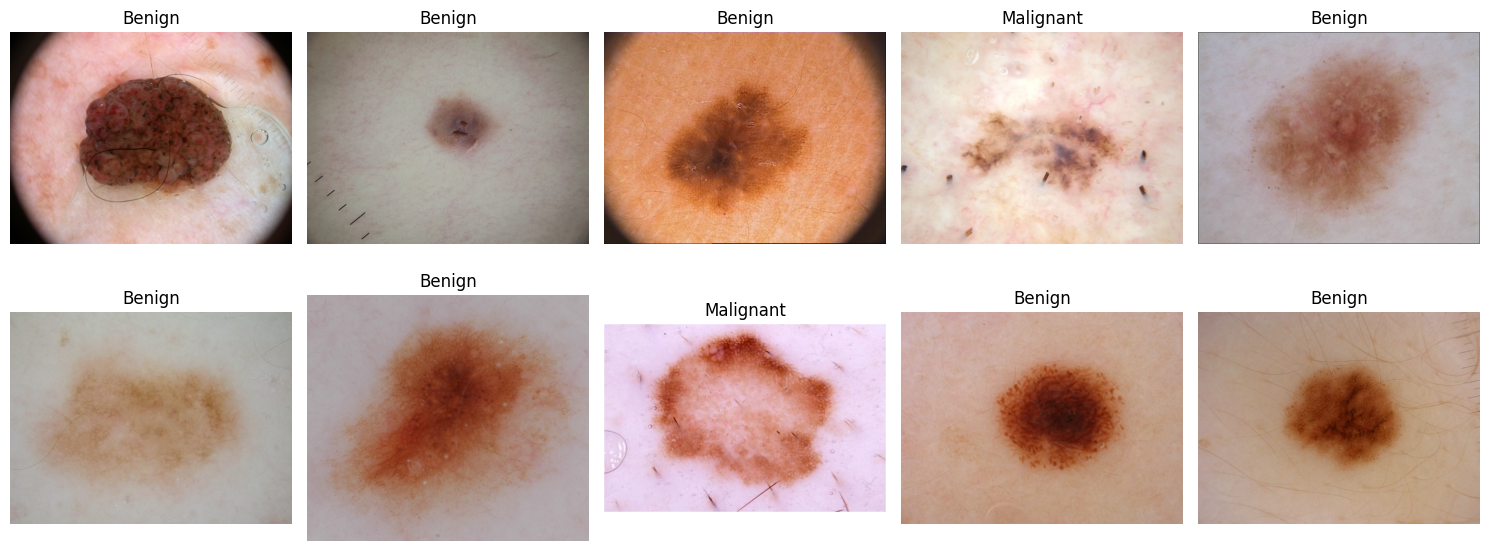

In [14]:
def plot_samples(labels_df, rows=2, cols=5, processor=None):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()
    sampled_df = labels_df.sample(n=rows * cols, random_state=42)
    for i, (index, row) in enumerate(sampled_df.iterrows()):
        image_path = row['file_path']
        label = row['label']
        
        image = Image.open(image_path).convert("RGB")
        
        if processor:
            image = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0).permute(1, 2, 0).numpy()
        else:
            image = np.array(image)

        axes[i].imshow(image)
        axes[i].set_title('Malignant' if label == 1 else 'Benign')  # Set title based on the label
        axes[i].axis('off')  # Turn off axes
    plt.tight_layout()
    plt.show()

plot_samples(final_df_training)
# plot_samples(validation_labels_df)

## Data Augmentation

### Saving Dataset to hub

In [ ]:
# dataset_dict = DatasetDict({
#     "train": final_df_training,
#     "validation": final_df_validation,
#     "test": final_df_test
# })

# # dataset_dict.push_to_hub("cs198-cvmig/isic2016-2017_augmented_224")

# dataset_dict

DatasetDict({
    train:             image_id  label                                          file_path
    0       ISIC_0000000    0.0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
    1       ISIC_0000001    0.0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
    2       ISIC_0000002    1.0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
    3       ISIC_0000004    1.0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
    4       ISIC_0000006    0.0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
    ...              ...    ...                                                ...
    1195  ISIC_0015219_1    1.0  datasets/temp/augmented_images/ISIC_0015219_1.jpg
    1196  ISIC_0015219_2    1.0  datasets/temp/augmented_images/ISIC_0015219_2.jpg
    1197  ISIC_0015284_0    1.0  datasets/temp/augmented_images/ISIC_0015284_0.jpg
    1198  ISIC_0015284_1    1.0  datasets/temp/augmented_images/ISIC_0015284_1.jpg
    1199  ISIC_0015284_2    1.0  datasets/temp/augmented_images/IS

## Classification using Vision Transformers

### Defining Dataset for ViT

In [7]:
class ISICDatasetTransform(Dataset):
    def __init__(self, labels_df, processor=None):
        self.labels_df = labels_df
        self.processor = processor

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        image = Image.open(row['file_path']).convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt")
        label = row['label']
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        
        return inputs

### Loading Model and Processor

In [8]:
def load_model_and_processor(model_name):
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes = True
    )
    for name,p in model.named_parameters():
        if not name.startswith('classifier'):
            p.requires_grad = False

    num_params = sum([p.numel() for p in model.parameters()])
    trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

    print(f"{num_params = :,} | {trainable_params = :,}")

    return model, processor

### Data Collator Function

In [9]:
def collate_fn(batch):
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in batch])
    labels = torch.tensor([x['labels'] for x in batch])
    
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

### Metric Computation for Evaluation

In [10]:
from sklearn.metrics import recall_score, confusion_matrix, average_precision_score, roc_auc_score, accuracy_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, axis=1).numpy()  # Get predicted classes
    probabilities = torch.softmax(logits, dim=1)[:, 1].numpy()  # Probabilities for class 1

    # Accuracy
    accuracy_score_value = accuracy_score(labels, predictions)
    
    # Sensitivity (Recall for positive class)
    sensitivity_score = recall_score(labels, predictions, pos_label=1)
    
    # Specificity
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity_score = tn / (tn + fp)
    
    # Average Precision
    avg_precision = average_precision_score(labels, probabilities)
    
    # AUC-ROC
    auc_score = roc_auc_score(labels, probabilities)

    wandb.log({
        'accuracy': accuracy_score_value,
        'sensitivity': sensitivity_score,
        'specificity': specificity_score,
        'average_precision': avg_precision,
        'auc_roc': auc_score
    })
    
    return {
        'accuracy': accuracy_score_value,
        'sensitivity': sensitivity_score,
        'specificity': specificity_score,
        'average_precision': avg_precision,
        'auc_roc': auc_score
    }

## Model Training and Evaluation

### Ready Results

In [34]:
import json
output_file = './output/model_comparison.json'
try:
    with open(output_file, 'r') as f:
        results = json.load(f)
except FileNotFoundError:
    results = {}

### Training Loop

In [37]:
import torch

model_name = "facebook/deit-base-patch16-224" # "google/vit-base-patch16-224", "facebook/deit-base-patch16-224", "microsoft/swinv2-base-patch4-window8-256" 
unique_model_name = f'{model_name.replace("/","-")}_isic2016'
wandb.init(project='skin_cancer_detection', name=unique_model_name)

# Load model and processor
model, processor = load_model_and_processor(model_name)

# Prepare dataset with processor's transformations
train_dataset = ISICDatasetTransform(final_df_training, processor)
eval_dataset = ISICDatasetTransform(final_df_validation, processor)
test_dataset = ISICDatasetTransform(final_df_test, processor)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir=f'./results/{unique_model_name}',
    hub_model_id=f'cs198-cvmig/{unique_model_name}',
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=3e-4,
    save_total_limit=1,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to=['wandb','tensorboard'],
    load_best_model_at_end=True,
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
)

# Train and evaluate
print(f"Training and evaluating model: {model_name}")
trainer.train(resume_from_checkpoint=True) # Set to True to resume training
eval_results = trainer.evaluate(test_dataset)
results[unique_model_name] = eval_results

wandb.finish()

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\win10\AppData\Local\Temp\ipykernel_7220\4047577240.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


num_params = 85,800,194 | trainable_params = 1,538
Training and evaluating model: facebook/deit-base-patch16-224


c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(

{'loss': 0.3839, 'grad_norm': 1.2274004220962524, 'learning_rate': 0.0001421052631578947, 'epoch': 5.26}


 60%|██████    | 342/570 [00:58<02:37,  1.45it/s]

{'eval_loss': 0.42752334475517273, 'eval_accuracy': 0.8095238095238095, 'eval_sensitivity': 0.10810810810810811, 'eval_specificity': 0.9802631578947368, 'eval_average_precision': 0.45208574599313245, 'eval_auc_roc': 0.7654694167852063, 'eval_runtime': 8.9876, 'eval_samples_per_second': 21.029, 'eval_steps_per_second': 2.67, 'epoch': 6.0}


 70%|███████   | 399/570 [01:56<02:06,  1.35it/s]

{'eval_loss': 0.42504051327705383, 'eval_accuracy': 0.798941798941799, 'eval_sensitivity': 0.05405405405405406, 'eval_specificity': 0.9802631578947368, 'eval_average_precision': 0.4598615252287338, 'eval_auc_roc': 0.7679587482219061, 'eval_runtime': 9.2508, 'eval_samples_per_second': 20.431, 'eval_steps_per_second': 2.594, 'epoch': 7.0}


 70%|███████   | 400/570 [01:59<08:52,  3.13s/it]

{'loss': 0.3942, 'grad_norm': 2.67289400100708, 'learning_rate': 8.94736842105263e-05, 'epoch': 7.02}


 80%|████████  | 456/570 [02:55<01:17,  1.47it/s]

{'eval_loss': 0.4230847954750061, 'eval_accuracy': 0.798941798941799, 'eval_sensitivity': 0.05405405405405406, 'eval_specificity': 0.9802631578947368, 'eval_average_precision': 0.4660008992568854, 'eval_auc_roc': 0.772226173541963, 'eval_runtime': 9.1416, 'eval_samples_per_second': 20.675, 'eval_steps_per_second': 2.625, 'epoch': 8.0}


 88%|████████▊ | 500/570 [03:34<01:03,  1.10it/s]

{'loss': 0.3839, 'grad_norm': 1.58461594581604, 'learning_rate': 3.684210526315789e-05, 'epoch': 8.77}


 90%|█████████ | 513/570 [03:53<00:34,  1.63it/s]

{'eval_loss': 0.42247551679611206, 'eval_accuracy': 0.798941798941799, 'eval_sensitivity': 0.05405405405405406, 'eval_specificity': 0.9802631578947368, 'eval_average_precision': 0.46854032603823115, 'eval_auc_roc': 0.7738264580369844, 'eval_runtime': 9.8249, 'eval_samples_per_second': 19.237, 'eval_steps_per_second': 2.443, 'epoch': 9.0}


100%|██████████| 570/570 [04:55<00:00,  1.67it/s]

{'eval_loss': 0.4221494495868683, 'eval_accuracy': 0.798941798941799, 'eval_sensitivity': 0.05405405405405406, 'eval_specificity': 0.9802631578947368, 'eval_average_precision': 0.4693364214964526, 'eval_auc_roc': 0.7743598862019915, 'eval_runtime': 9.9655, 'eval_samples_per_second': 18.965, 'eval_steps_per_second': 2.408, 'epoch': 10.0}


100%|██████████| 570/570 [04:55<00:00,  1.93it/s]


{'train_runtime': 295.7391, 'train_samples_per_second': 30.432, 'train_steps_per_second': 1.927, 'train_loss': 0.19321170020521733, 'epoch': 10.0}


100%|██████████| 24/24 [00:09<00:00,  2.58it/s]


accuracy,▄▁▁▁▁█
auc_roc,▂▃▆██▁
average_precision,▁▂▂▂▂█
eval/accuracy,▄▁▁▁▁█
eval/auc_roc,▂▃▆██▁
eval/average_precision,▁▂▂▂▂█
eval/loss,█▇▆▅▅▁
eval/runtime,▁▃▂▆▇█
eval/samples_per_second,█▆▇▃▂▁
eval/sensitivity,▅▁▁▁▁█
eval/specificity,▁▁▁▁▁█


### Results for Comparison

In [38]:
# Print out the results for comparison
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print("\n")


# Save the results in JSON format
with open(output_file, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {output_file}")

Model: google-vit-base-patch16-224_isic2016
  eval_loss: 0.4046
  eval_accuracy: 0.8158
  eval_sensitivity: 0.1316
  eval_specificity: 0.9868
  eval_average_precision: 0.5019
  eval_auc_roc: 0.8151
  eval_runtime: 10.5244
  eval_samples_per_second: 18.0530
  eval_steps_per_second: 2.2800
  epoch: 10.0000


Model: facebook-deit-base-patch16-224_isic2016
  eval_loss: 0.4142
  eval_accuracy: 0.8263
  eval_sensitivity: 0.1579
  eval_specificity: 0.9934
  eval_average_precision: 0.5536
  eval_auc_roc: 0.7647
  eval_runtime: 10.1352
  eval_samples_per_second: 18.7460
  eval_steps_per_second: 2.3680
  epoch: 10.0000


Model: microsoft-swinv2-base-patch4-window8-256_isic2016
  eval_loss: 0.3921
  eval_accuracy: 0.8105
  eval_sensitivity: 0.0789
  eval_specificity: 0.9934
  eval_average_precision: 0.6221
  eval_auc_roc: 0.8426
  eval_runtime: 13.4258
  eval_samples_per_second: 14.1520
  eval_steps_per_second: 1.7880
  epoch: 10.0000


Results saved to ./output/model_comparison.json


## Adjust Threshold

In [40]:
from transformers import AutoModelForImageClassification

# Define the function to load the trained model from the output directory
def load_trained_model(model_name):
    # Load processor
    processor = AutoImageProcessor.from_pretrained(model_name)

    # Load the model from the output directory
    trained_model = AutoModelForImageClassification.from_pretrained(model_name)
    
    return trained_model, processor

model_name = "cs198-cvmig/google-vit-base-patch16-224_isic2016"  # Adjust this to match the model you trained

trained_model, processor = load_trained_model( model_name)


c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\win10\.cache\huggingface\hub\models--cs198-cvmig--google-vit-base-patch16-224_isic2016. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


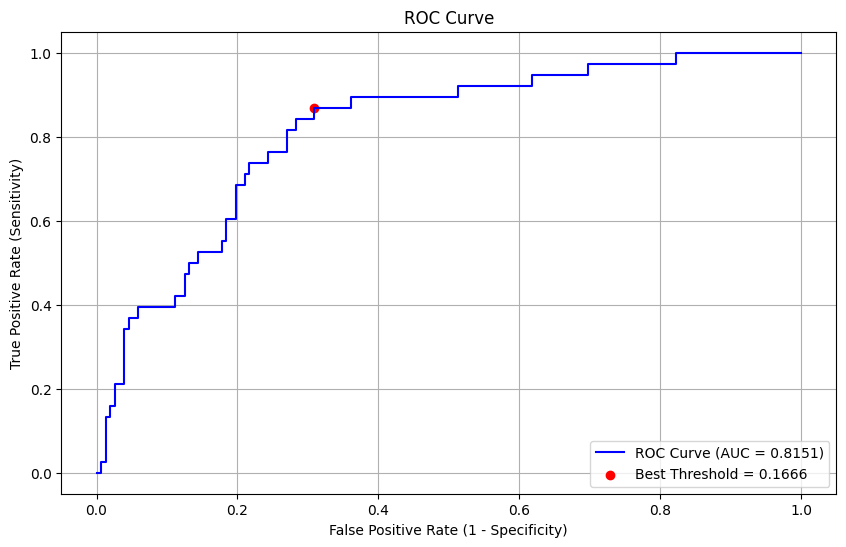

Evaluation Results:
roc_auc: 0.8151
accuracy: 0.7263
sensitivity: 0.8684
specificity: 0.6908
average_precision: 0.5019
best_threshold: 0.1666


In [46]:
import numpy as np
from sklearn.metrics import roc_curve, auc, recall_score, confusion_matrix, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def evaluate_with_threshold(trained_model, processor, dataset):
    """
    Evaluate a trained model, compute ROC curve, and find the best threshold.
    """
    # Put model in evaluation mode
    trained_model.eval()

    # Get predictions and labels
    probabilities = []
    labels = []
    
    with torch.no_grad():
        for item in dataset:
            inputs = {k: v.to(trained_model.device) for k, v in item.items() if k != 'labels'}
            outputs = trained_model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            probabilities.extend(probs)
            labels.extend(item['labels'].numpy())

    probabilities = np.array(probabilities)
    labels = np.array(labels)

    # Compute ROC Curve
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)

    # Find the best threshold (adjust criterion if needed)
    best_threshold_index = np.argmax(tpr - fpr)  # Change to np.argmax(tpr - 0.5*fpr) to prioritize sensitivity more
    best_threshold = thresholds[best_threshold_index]

    # Make predictions with the selected threshold
    adjusted_predictions = (probabilities >= best_threshold).astype(int)

    # Metrics with adjusted threshold
    accuracy_score_value = accuracy_score(labels, adjusted_predictions)
    sensitivity_score = recall_score(labels, adjusted_predictions, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(labels, adjusted_predictions).ravel()
    specificity_score = tn / (tn + fp)
    avg_precision = average_precision_score(labels, probabilities)

    # Plot ROC Curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.4f}')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Return results
    results = {
        'roc_auc': roc_auc,
        'accuracy': accuracy_score_value,
        'sensitivity': sensitivity_score,
        'specificity': specificity_score,
        'average_precision': avg_precision,
        'best_threshold': best_threshold
    }

    return results

# Usage Example
test_dataset = ISICDatasetTransform(final_df_test, processor)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn)

# Evaluate model after training
results = evaluate_with_threshold(trained_model, processor, test_loader)
print("Evaluation Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")
